In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize
from pymatsolver import Pardiso as Solver
from SimPEG import maps, data
# from SimPEG import maps, utils, data, optimization, maps, objective_function, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from discretize.utils import mkvc, ndgrid, active_from_xyz
from SimPEG.meta import MultiprocessingMetaSimulation
from SimPEG.utils import plot2Ddata, surface2ind_topo
%autosave 0

Autosave disabled


Forward modeling synthetic ZTEM data.

Based on this notebook: https://github.com/simpeg-research/heagy-et-al-2023-aem/tree/main/mt/airborne_tipper

## Problem set up
Define survey


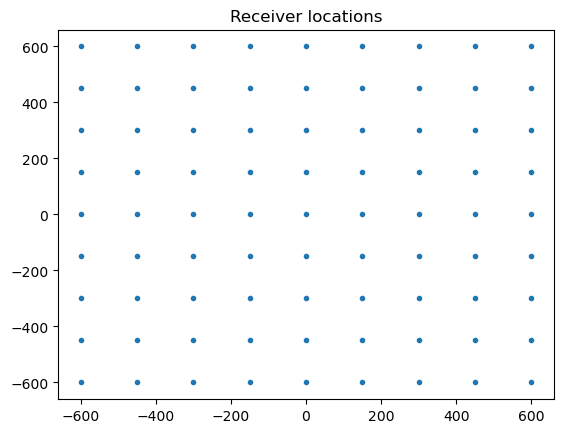

In [2]:
receiver_locations = ndgrid(np.arange(-600, 650, 150),np.arange(-600, 650, 150),)
rx_z = np.ones_like(receiver_locations[:,0]) * 50
receiver_locations = np.c_[receiver_locations,rx_z]

plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], '.')
plt.title('Receiver locations')
plt.show()


## Mesh Design
For FDEM data, the mesh extent should be informed by the skin depth of the lowest and highest frequencies. The skin depth is given by:

\begin{equation}
\delta \approx 500 \sqrt{\frac{1}{\sigma {f}}}
\end{equation}

For ZTEM the lowest frequency is 30 Hz and highest is 720 Hz.
So assuming the background conductivity of 0.01 S/m,
skin depth for the highest frequency is 188 m and for the lowest frequency is 918 m.

The minimum cell size must be smaller than the minimum skin depth (typically 1/3 times), and the mesh size should extend to at least 2-3 times the maximum skin depths from the Tx.

For this example we will model a block in the center of the mesh with conductivity of 10 S/m.
For now, topography is assumed to be flat.

In [3]:
# domain OcTree mesh

dh = 50.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 6000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = discretize.TreeMesh([hx, hy, hz], x0="CCC")

#define core extent
core_points = ndgrid(
    np.r_[-800, 1000], np.r_[-800, 1000], np.r_[-800,50]
)

#Refine mesh around core region
mesh.refine_bounding_box(core_points, -1, padding_cells_by_level=[2, 2, 4], finalize=False)

#refine around receivers
mesh.refine_points(receiver_locations, padding_cells_by_level=[2, 2, 4], finalize=False)

mesh.finalize()
mesh

OcTreeMesh: 2.35% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       272            ---------------------------   --------------------
  4   :       952         x:    -3200.0   ,   3200.0          50.0   ,   800.0   
  5   :      6392         y:    -3200.0   ,   3200.0          50.0   ,   800.0   
  6   :      6416         z:    -3200.0   ,   3200.0          50.0   ,   800.0   
  7   :      35200     
-----------------------
Total :      49232

# Define model


In [4]:
# Define conductivity model on the mesh
sig_back = 1e-3
sig_block = 10
sig_air = 1e-8

model = sig_air * np.ones(mesh.nC)
model[mesh.cell_centers[:, 2] < 0] = sig_back
halfspace = model.copy()

ind_block1 = (
    (mesh.cell_centers[:, 0] > 0) & (mesh.cell_centers[:, 0] < 300) &
    (mesh.cell_centers[:, 1] > -300) & (mesh.cell_centers[:, 1] < 300) &
    (mesh.cell_centers[:, 2] > -500) & (mesh.cell_centers[:, 2] < -100)
)
ind_block2 = (
    (mesh.cell_centers[:, 0] > -300) & (mesh.cell_centers[:, 0] < 0) &
    (mesh.cell_centers[:, 1] > -100) & (mesh.cell_centers[:, 1] < 300) &
    (mesh.cell_centers[:, 2] > -500) & (mesh.cell_centers[:, 2] < -100)
)
model[ind_block1] = sig_block
model[ind_block2] = sig_block


# Mapping

In [5]:
# Set the mapping between the model and forward simulation
#First we need to create a boolean array to tell the simulation which cells are active
#Air cells are excluded
active_inds = model > sig_air
actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
# Conductivity changes logarithmically so we set it as an exponential map
mapping = maps.ExpMap(mesh) * actMap
active_model = model[active_inds]

Text(0, 0.5, 'y (m)')

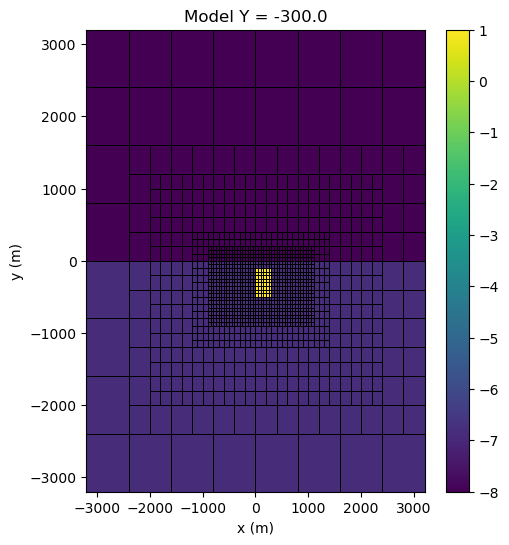

In [8]:
# Plot the model
plot_map = maps.LogMap(mesh)*model
plot_ind = np.where(mesh.nodes_y==-300)[0][0]
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
out = mesh.plot_slice(plot_map, normal='y', ax=ax1,ind=plot_ind, grid=True, pcolor_opts={"vmin":np.log10(sig_air), "vmax":np.log10(sig_block)},
        grid_opts={"color":"k", "lw":0.5},)
cb = plt.colorbar(out[0], orientation="vertical")
#plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'w.',alpha=0.75)
ax1.set_title(f"Model Y = {mesh.nodes_y[int(plot_ind)]}")
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')


# Define survey

In [7]:
frequencies = np.r_[30, 45, 90, 180, 360, 720] #Choose frequencies to simulate (currently includes 6 standard ZTEM frequencies) 
#choose fewer freqs for testing code on laptop

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:

    # specify that we are using tipper data
    rx_real = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "real")
    rx_imag = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "imag")

    # append to the receiver list
    rx_list.append(rx_real)
    rx_list.append(rx_imag)

# Source list
source_list = [
    nsem.sources.PlanewaveXYPrimary(rx_list, frequency=freq) for freq in frequencies
]

# Survey object
survey = nsem.Survey(source_list)


# Define the forward simulation

In [8]:
#Using multiprocessing and splitting the simulation for each frequency on different core
mappings = []
sims = []
for src in source_list:
    mappings.append(maps.IdentityMap())
    srv_piece = nsem.Survey([src,])
    sims.append(nsem.Simulation3DPrimarySecondary(
        mesh, survey=srv_piece, sigmaMap=mapping, sigmaPrimary=halfspace, solver=Solver
    ))

sim = MultiprocessingMetaSimulation(sims, mappings)
sim.model = halfspace[active_inds]
# Predict fields and data for a synthetic model
fields= sim.fields(np.log(model[active_inds]))
dobs = sim.dpred(np.log(model[active_inds]), f=fields)

# #If multiprocessing is unstable or undesired use below instead
# sim = nsem.Simulation3DPrimarySecondary(
#     mesh, survey=survey, solver=Solver, sigmaMap=mapping, sigmaPrimary=halfspace
# )

# # Predict fields and data for a synthetic model
# fields= sim.fields(model[active_inds])
# dobs = sim.dpred(model[active_inds], f=fields)

/home/ppokar/miniconda/envs/nsem/lib/python3.11/site-packages/SimPEG/meta/multiprocessing.py:227: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/home/ppokar/miniconda/envs/nsem/lib/python3.11/site-packages/SimPEG/meta/multiprocessing.py:246: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


In [12]:
data_obj = data.Data(survey, dobs=dobs)

# Plot results

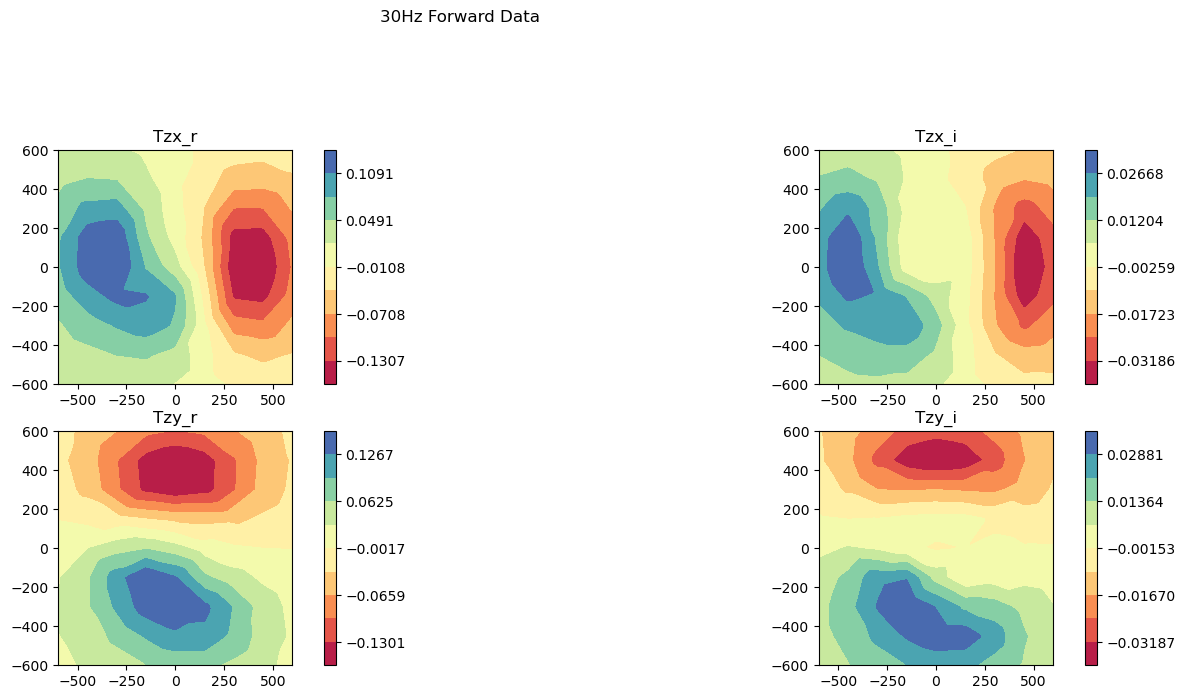

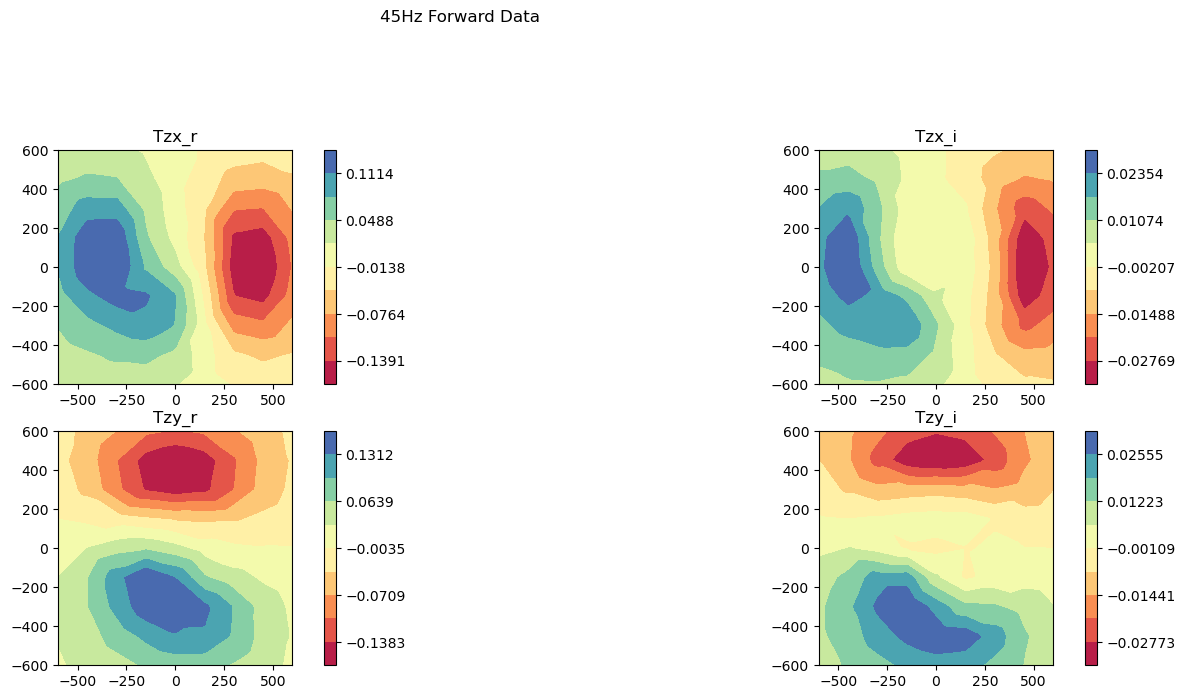

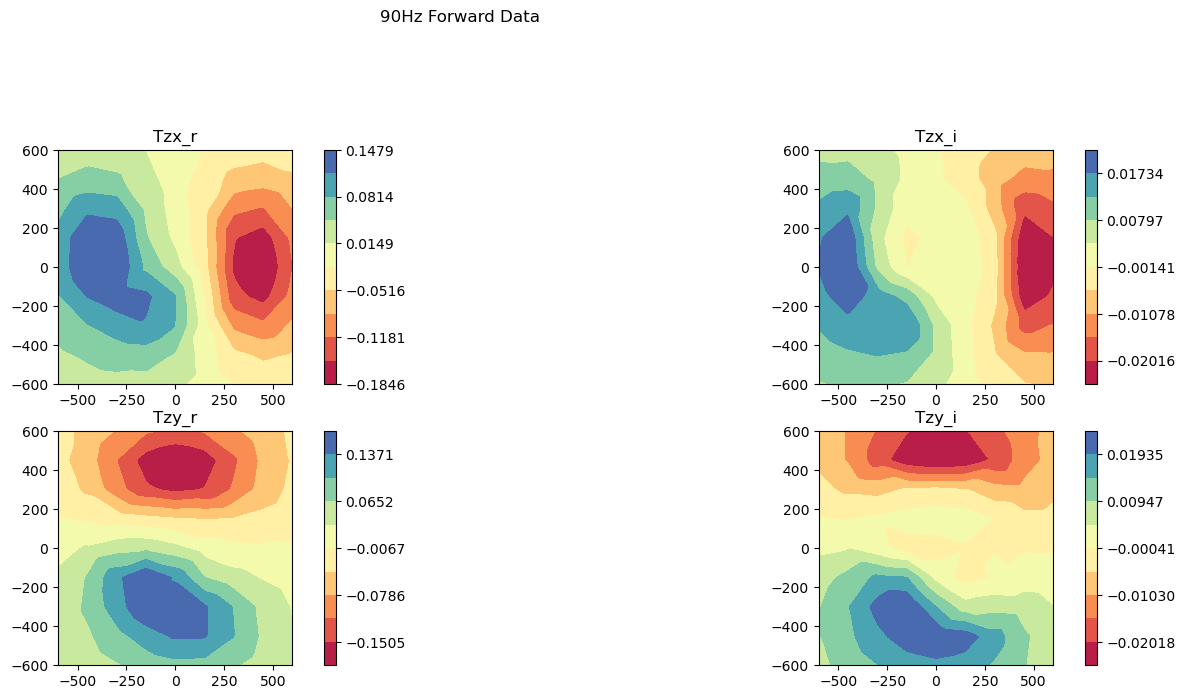

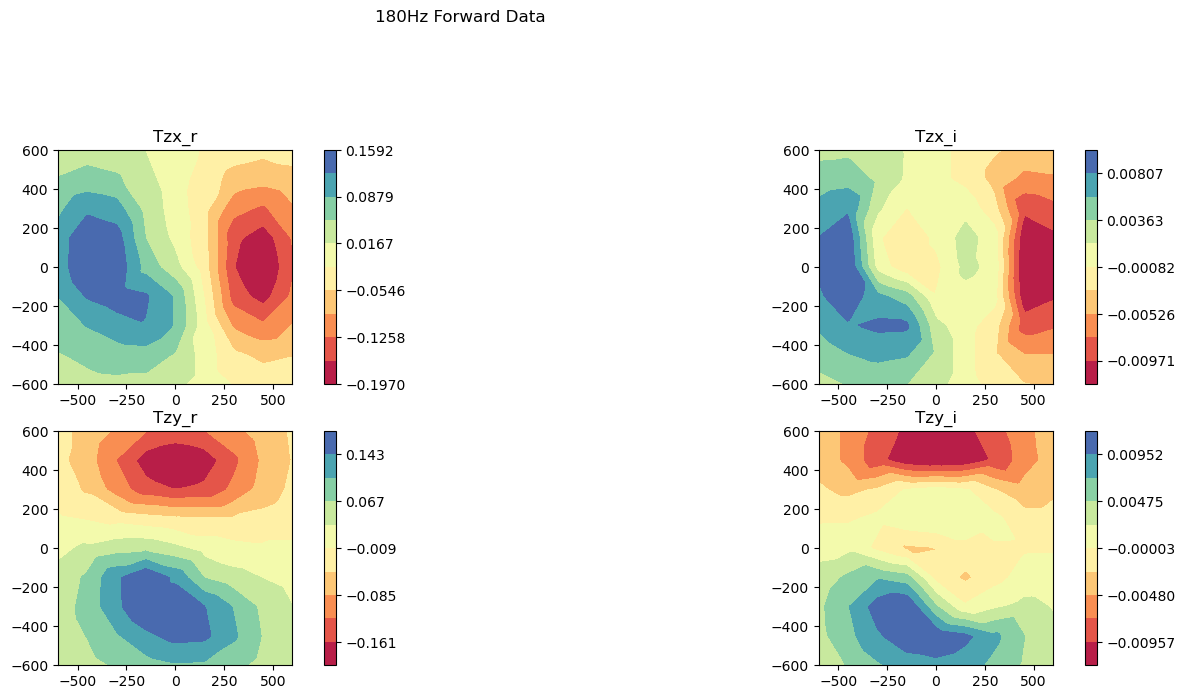

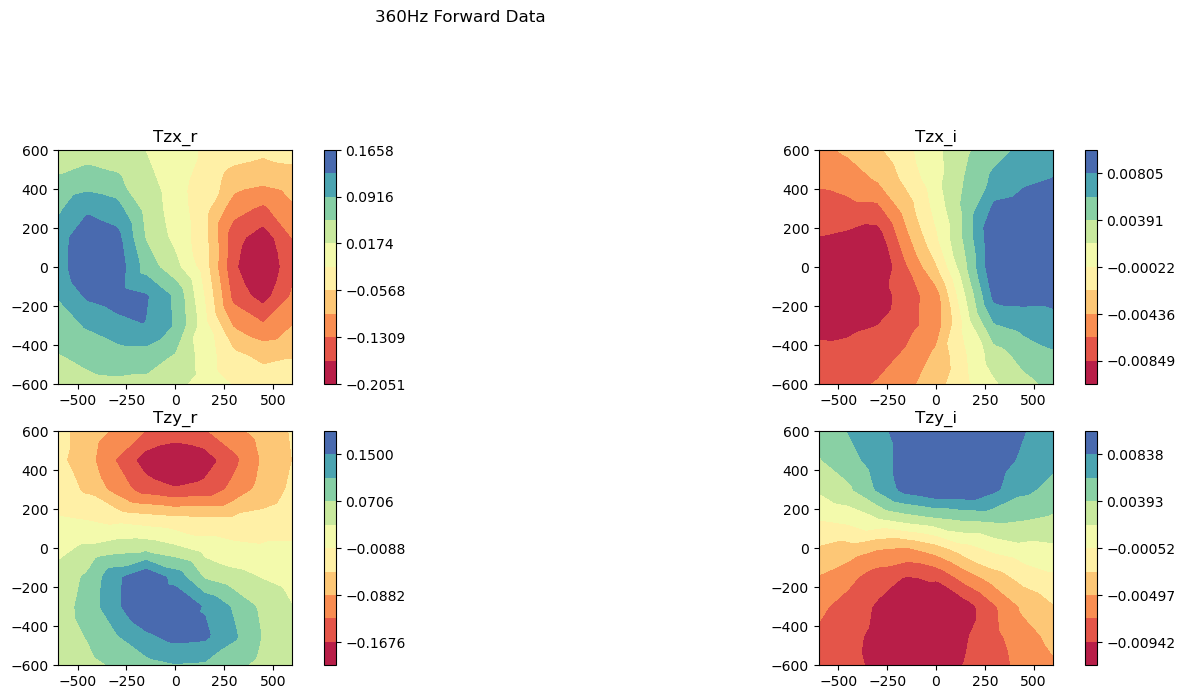

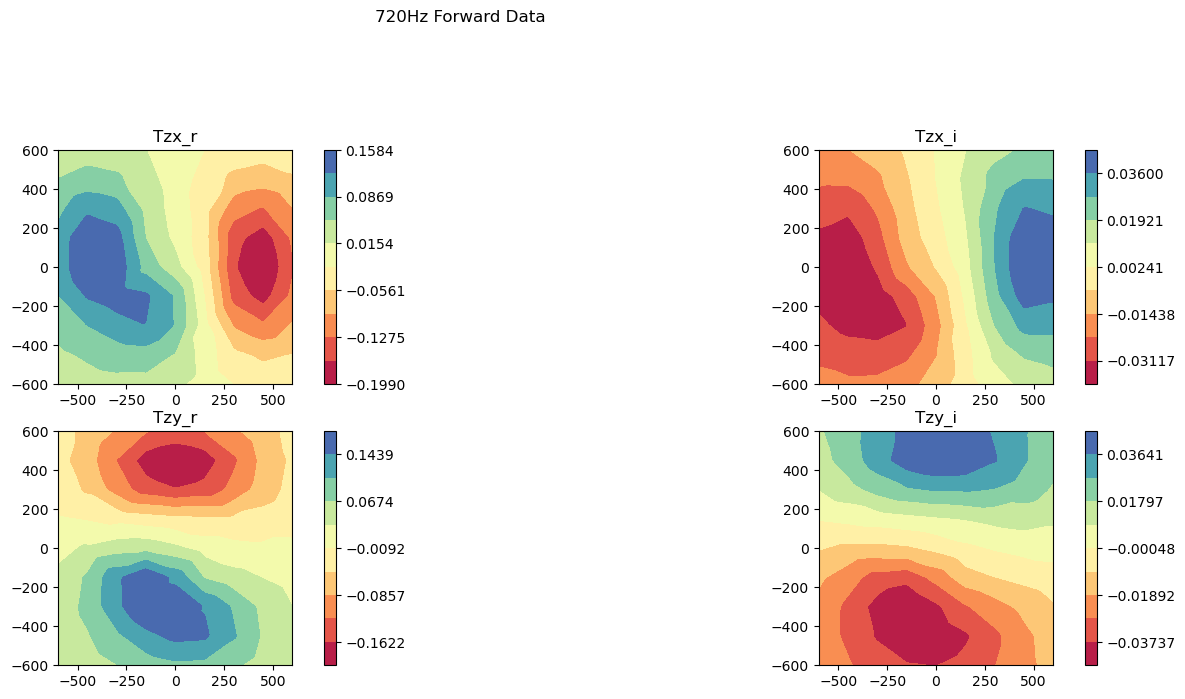

<Figure size 640x480 with 0 Axes>

In [13]:
# reshape data for plotting
num_station = receiver_locations.shape[0]
num_frequencies = len(frequencies)
#number of plots for each freq num_stations*(number of components + number of tippers). 
#here it is 36*(2+2)=144
num_sets = int(data_obj.dobs.shape[0] / len(frequencies)) 
dplot = np.reshape(data_obj.dobs, (num_frequencies, num_sets)) #rearrage data for plotting (num freqs,num sets)
stdplot = np.reshape(data_obj.standard_deviation, (num_frequencies, num_sets)) #track standard deviation for each datapoint

cnt = 0

for freq in frequencies:
    cnt_comp = 0
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = plot2Ddata(receiver_locations, dplot[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f"{freq}Hz Forward Data")    
plt.show()
plt.tight_layout()

# Exporting data, mesh and model
Before exporting data we add some noise to be able to use it for inversion

In [21]:
#add 2% noise to the data before exporting
np.random.seed(39)
std = 0.02 * np.abs(dobs)
noise = std * np.random.rand(len(dobs))
dobs_export = dobs + noise
#Export synthetic data
np.savetxt(r"..\data\ztem_syn_fwd_all-freq.obs", dobs_export)

## Export mesh
mesh.write_UBC(r"..\data\ztem_all-freq.msh")
## Export model
mesh.write_model_UBC(r"..\data\ztem_all-freq.mod",model)